In [1]:
!pip install roboflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0


In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torchvision.models.detection import SSDLite320_MobileNet_V3_Large_Weights
from torchvision import transforms as T
from torch.utils.data import DataLoader, TensorDataset, Dataset
import json
from collections import defaultdict
import pandas as pd
import numpy as np

import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from roboflow import Roboflow
import random



In [3]:
CLASS_COLORS = {
    "1": 'r',
    "2": 'w',
}
CLASS_NAMES ={
    "1": "Car",
    "2": "Plate"
}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
rf = Roboflow(api_key="IYwf0SjALphOAs60cx0U")
project = rf.workspace("myworkspace-zkmzj").project("license-plate-detector-no-brand")
version = project.version(2)
dataset = version.download("coco")



loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to License-Plate-Detector---no-brand-2 in coco:: 100%|██████████| 4518/4518 [00:02<00:00, 1991.62it/s]


#Extract Data from Project Folders


In [5]:
# # Define paths to your dataset folders
train_folder = "License-Plate-Detector---no-brand-2/train/"
test_folder = "License-Plate-Detector---no-brand-2/test/"
val_folder = "License-Plate-Detector---no-brand-2/valid/"

# # Get list of all image files in the images folder
def extract_file_paths(dir):
  json_file = ''
  for f in os.listdir(dir):
    if f.endswith('.json'):
      json_file = dir+f
  return json_file

train_label_file = extract_file_paths(train_folder)
val_label_file = extract_file_paths(val_folder)
test_label_file = extract_file_paths(test_folder)

train_label_file, test_label_file

('License-Plate-Detector---no-brand-2/train/_annotations.coco.json',
 'License-Plate-Detector---no-brand-2/test/_annotations.coco.json')

In [6]:
def extract_image_paths(dir):
  image_files = []
  for f in os.listdir(dir):
    if f.endswith('.jpg'):
      image_files.append(dir+f)

  return image_files

train_image_files = extract_image_paths(train_folder)
val_image_files = extract_image_paths(val_folder)
test_image_files = extract_image_paths(test_folder)

train_image_files[:5]

['License-Plate-Detector---no-brand-2/train/53ad98b12752ad16_jpg.rf.4d711d9585d7e2ef7c0c14f4b6a899fb.jpg',
 'License-Plate-Detector---no-brand-2/train/0df9ddce-e86d-4832-9982-3af0336137ad_jpg.rf.ca94dc7919fff1ba80a485899e63bf2f.jpg',
 'License-Plate-Detector---no-brand-2/train/ed7d99098d4af8e6_jpg.rf.3f263d5e89372aaf4f0a299781724ca5.jpg',
 'License-Plate-Detector---no-brand-2/train/IMG_0776_jpg.rf.ede1af5ebedc7193cf5c0f80db6befe7.jpg',
 'License-Plate-Detector---no-brand-2/train/IMG_0624_jpg.rf.84bc179a6f1da02661fc13c4ccc2438e.jpg']

In [7]:
# Opens annotation file
def extract_annotations(label_file):
  f= open(label_file)
  anns =json.load(f)
  return anns

train_anns = extract_annotations(train_label_file)
test_anns = extract_annotations(test_label_file)
val_anns = extract_annotations(val_label_file)

In [8]:
train_anns['annotations'][5], train_anns['categories'], train_anns['images'][0]

({'id': 5,
  'image_id': 1,
  'category_id': 1,
  'bbox': [155, 206, 112, 49],
  'area': 5488,
  'segmentation': [],
  'iscrowd': 0},
 [{'id': 0, 'name': '-cars--h9y9', 'supercategory': 'none'},
  {'id': 1, 'name': 'Car', 'supercategory': '-cars--h9y9'},
  {'id': 2, 'name': 'Plate', 'supercategory': '-cars--h9y9'}],
 {'id': 0,
  'license': 1,
  'file_name': 'IMG_0596_jpg.rf.87c28eed2fc5b4c8d2b404fdbb7753d9.jpg',
  'height': 640,
  'width': 640,
  'date_captured': '2024-07-10T18:40:02+00:00'})

In [9]:
def create_dfs(dir, anns):
  img_df = pd.DataFrame(anns['images'])
  img_df.drop(['height', 'width', 'date_captured', 'license'],axis=1, inplace=True)
  img_df['file_name'] = dir+img_df['file_name']

  ann_df = pd.DataFrame(anns['annotations'])
  ann_df.drop(['segmentation', 'iscrowd', 'area'], axis=1, inplace=True)
  # Extracting bbox values and creating new columns
  ann_df[['x1', 'y1', 'w', 'h']] = pd.DataFrame(ann_df['bbox'].tolist(), index=ann_df.index)
  ann_df['x2'] = ann_df['x1'] + ann_df['w']
  ann_df['y2'] = ann_df['y1'] + ann_df['h']

  ann_df.drop(['w', 'h', 'bbox'], axis=1, inplace=True)

  return img_df, ann_df

In [10]:
train_img_df, train_ann_df = create_dfs(train_folder,train_anns)
test_img_df, test_ann_df = create_dfs(test_folder,test_anns)
val_img_df, val_ann_df = create_dfs(val_folder,val_anns)


In [11]:
train_img_df.head()

,id,file_name,extra
0,0,License-Plate-Detector---no-brand-2/train/IMG_...,NaN
1,1,License-Plate-Detector---no-brand-2/train/IMG_...,NaN
2,2,License-Plate-Detector---no-brand-2/train/IMG_...,NaN
3,3,License-Plate-Detector---no-brand-2/train/IMG_...,NaN
4,4,License-Plate-Detector---no-brand-2/train/f3qb...,{'user_tags': ['Object-detection']}


In [12]:
train_ann_df.head()

,id,image_id,category_id,x1,y1,x2,y2
0,0,0,2,272,397,378.0,456.5
1,1,0,1,216,191,640.0,526.0
2,2,1,2,226,385,318.0,426.0
3,3,1,1,0,184,153.0,344.0
4,4,1,1,166,200,529.0,480.0


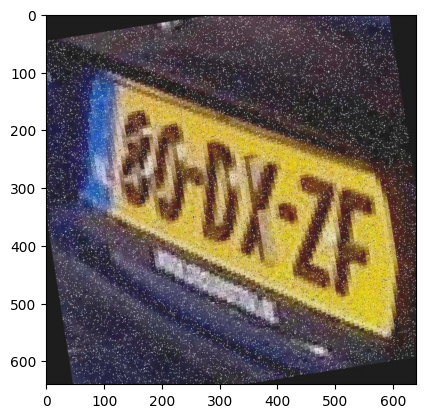

In [13]:
def plot_image_from_df(file_path):
  img = Image.open(file_path)
  fig, ax = plt.subplots()
  ax.imshow(img)
  plt.show()

img_id = 21
plot_image_from_df(train_img_df['file_name'][train_img_df['id'] ==img_id][img_id])

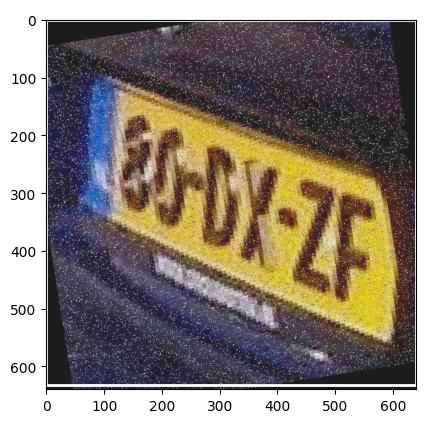

In [14]:
# Function to plot image with bounding boxes
def plot_image_with_annotations(image_id, img_df, ann_df):
    # Get the file path of the image
    image_path = img_df.loc[img_df['id'] == image_id, 'file_name'].values[0]

    # Load the image
    image = Image.open(image_path)

    # Extract annotations for the given image_id
    annots = ann_df[ann_df['image_id'] == image_id]
    # Plot the image
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Draw bounding boxes
    for _, row in annots.iterrows():
        rect = patches.Rectangle((row['x1'], row['y1']), row['x2'] - row['x1'], row['y2'] - row['y1'], linewidth=2, edgecolor=CLASS_COLORS[str(int(row['category_id']))], facecolor='none')

        ax.add_patch(rect)
        class_name = CLASS_NAMES[str(int(row['category_id']))]
        ax.text(row['x1'], row['y1'] - 5, class_name, color='white', fontsize=8)


    plt.show()

# Plot the image with id=0
plot_image_with_annotations(21, train_img_df, train_ann_df)

In [15]:
train_ann_df.columns, train_img_df.columns

(Index(['id', 'image_id', 'category_id', 'x1', 'y1', 'x2', 'y2'], dtype='object'),
 Index(['id', 'file_name', 'extra'], dtype='object'))

In [16]:
image_id = 0
annots = train_ann_df[train_ann_df['image_id'] == image_id]
boxes = annots[['x1', 'y1', 'x2', 'y2']].values
labels = annots['category_id'].values
boxes,labels

(array([[272. , 397. , 378. , 456.5],
        [216. , 191. , 640. , 526. ]]),
 array([2, 1]))

##Load model and prep for training

In [38]:
weights = SSDLite320_MobileNet_V3_Large_Weights.DEFAULT
num_classes = 3
custom_model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(num_classes=num_classes, weights_backbone='DEFAULT', trainable_backbone_layers=0)


preprocess = weights.transforms()
# weights_backbone=torchvision.models.MobileNet_V3_Large_Weights.DEFAULT,

In [18]:
class CustomDataset(Dataset):
    def __init__(self, image_df, annotations_df, transforms=None):
        self.image_df = image_df
        self.annotations_df = annotations_df
        self.transforms = transforms

    def __len__(self):
        return len(self.image_df)

    def __getitem__(self, idx):
        # Get image path and load image
        image_id = self.image_df.iloc[idx]['id']
        img_path = self.image_df.iloc[idx]['file_name']
        image = Image.open(img_path).convert("RGB")

        # Get annotations for the image
        annots = self.annotations_df[self.annotations_df['image_id'] == image_id]
        boxes = annots[['x1', 'y1', 'x2', 'y2']].values
        labels = annots['category_id'].values

        # Convert to PyTorch tensors


        if self.transforms is not None:
          image = self.transforms(image)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        return image, target


In [19]:
def collate_function(data):
  return data

In [28]:
# transforms = T.Compose([T.ToTensor()]) #T.Normalize((0.485,0.485,0.485),(0.229,0.224,0.225))
# transforms = T.Compose([
#     T.ToTensor(),                        # Convert PIL image to tensor
#     T.Resize((320, 320)),                # Resize image to 320x320
#     T.ConvertImageDtype(torch.float32),  # Convert pixel values to float32
#     T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to [0, 1]
# ])
train_set = CustomDataset(train_img_df, train_ann_df, preprocess)
val_set = CustomDataset(val_img_df, val_ann_df, preprocess)
test_set = CustomDataset(test_img_df, test_ann_df,preprocess)

In [29]:
train_loader = DataLoader(train_set,
                          batch_size=16,
                          shuffle = True,
                          drop_last=True,
                          collate_fn=collate_function)
val_loader = DataLoader(val_set,
                        batch_size=val_set.__len__(),
                        shuffle = True,
                        drop_last=True,
                        collate_fn=collate_function)
test_loader = DataLoader(test_set,
                        batch_size=test_set.__len__(),
                        shuffle = True,
                        drop_last=True,
                        collate_fn=collate_function)

#Training

##Pre Training Test

In [30]:
def test_inference(model):
  model.to(device)
  model.eval()
  with torch.no_grad():
    for data in test_loader:
      imgs = []
      for d in data:
        imgs.append(d[0].to(device))
      test_dict = model(imgs)
      break
  return test_dict, imgs

In [31]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from torchvision.ops import nms

def plot_predictions(image, boxes, scores, classes, class_names, score_threshold=0.4):
    # Create a figure and axis
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1,2,0).cpu())
    refined_boxes = nms(boxes, scores, 0.4)
    picked_boxes = boxes[refined_boxes]

    # Plot each bounding box
    for box, score, cls in zip(picked_boxes, scores, classes):
        if score >= score_threshold:
            x1, y1, x2, y2 = box
            # Create a rectangle patch
            rect = patches.Rectangle(
                (x1.item(), y1.item()), x2.item()-x1.item(), y2.item()-y1.item(), linewidth=2, edgecolor='r', facecolor='none'
            )
            print
            # Add the patch to the Axes
            ax.add_patch(rect)

            # Label with class name and score
            class_name = class_names[str(cls.item())]
            label = f'{class_name}: {score:.2f}'
            ax.text(x1, y1 - 10, label, color='white', fontsize=10, backgroundcolor='red')

            # Or label with the class number and the score
            # label = f'{str(cls.item())}:{score:.2f}'
            # ax.text(x1, y1 - 10, label, color='white', fontsize=10, backgroundcolor='red')


    # plt.axis('off')
    plt.grid()
    plt.show()




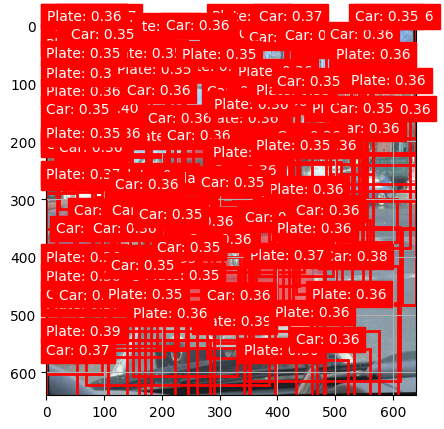

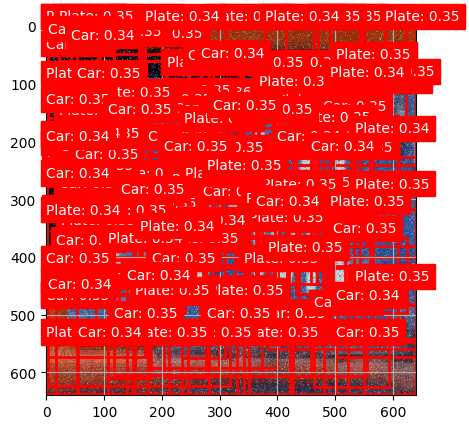

In [32]:
test_dict, test_imgs = test_inference(custom_model)
# Example usage
test_imgs_5 = test_imgs[:2]
test_labels_5 = test_dict[:2]
for i, image in enumerate(test_imgs_5):
  # image = cv2.imread(image)
  boxes = test_dict[i]['boxes']  # Example boxes
  scores = test_dict[i]['scores']  # Example scores
  classes = test_dict[i]['labels']  # Example classes  # Example class names
# print(classes)
  plot_predictions(image, boxes, scores, classes, CLASS_NAMES, 0.2)

##Fine Tuning

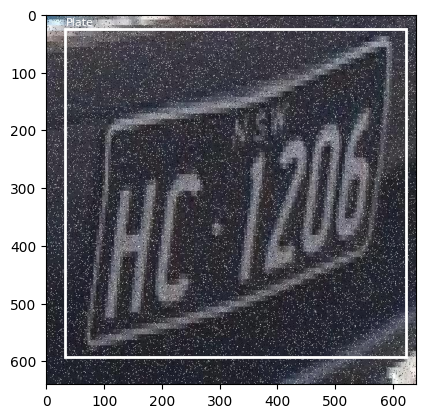

In [33]:
plot_image_with_annotations(0, test_img_df, test_ann_df)

##Training

In [34]:
custom_model

SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert

In [35]:
#Freeze back bone parameters
for param in custom_model.backbone.parameters():
  param.requires_grad = False

In [39]:
import sys
import torch
from torch.optim.lr_scheduler import StepLR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize optimizer
optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.0001)

# Initialize scheduler
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)  # Adjust learning rate every 5 epochs by multiplying with gamma

custom_model.to(device)
custom_model.train()

num_epochs = 10

train_losses = []
val_losses = []

for epoch in range(num_epochs):
  epoch_train_loss = []
  epoch_val_loss = []
  mini_batch = 1

  for data in train_loader:
    imgs = []
    targets = []
    for d in data:
      imgs.append(d[0].to(device))
      targ = {}
      targ['boxes'] = d[1]['boxes'].to(device)
      targ['labels'] = d[1]['labels'].to(device)
      targets.append(targ)

    # Forward pass
    loss_dict = custom_model(imgs, targets)
    loss = sum(loss for loss in loss_dict.values())
    epoch_train_loss.append(loss.item())

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Update learning rate scheduler
    # lr_scheduler.step()

    # Print progress
    message = f"\rEpoch: {epoch + 1}/{num_epochs}, Mini-Batch: {mini_batch}/{len(train_loader)}, Train Loss: {loss.item():.4f}"
    sys.stdout.write(message)
    sys.stdout.flush()

    mini_batch += 1

  # Validation loop
  # custom_model.eval()
  with torch.no_grad():
    for val_data in val_loader:
      val_imgs = []
      val_targets = []

      for d in val_data:
        val_imgs.append(d[0].to(device))
        val_targ = {}
        val_targ['boxes'] = d[1]['boxes'].to(device)
        val_targ['labels'] = d[1]['labels'].to(device)
        val_targets.append(val_targ)

      # Forward pass
      val_loss_dict = custom_model(val_imgs, val_targets)
      val_loss = sum(v for v in val_loss_dict.values())
      epoch_val_loss.append(val_loss.item())

  # Calculate average losses
  mean_epoch_train_loss = np.mean(epoch_train_loss[-5:])
  mean_epoch_val_lass = np.mean(epoch_val_loss[-5:])

  train_losses.append(mean_epoch_train_loss)
  val_losses.append(mean_epoch_val_lass)

  custom_model.train()


Epoch: 10/10, Mini-Batch: 250/250, Train Loss: 3.3790

In [40]:
train_losses, val_losses

([5.176955223083496,
  4.334409093856811,
  4.0751060962677,
  3.691781234741211,
  3.5685801029205324,
  3.5874667167663574,
  3.309177112579346,
  3.3632789611816407,
  3.4508260250091554,
  3.1607948303222657],
 [5.3806915283203125,
  4.646523475646973,
  4.306857109069824,
  4.108394145965576,
  3.985342502593994,
  3.902230739593506,
  3.8193674087524414,
  3.775196075439453,
  3.7267606258392334,
  3.718906879425049])

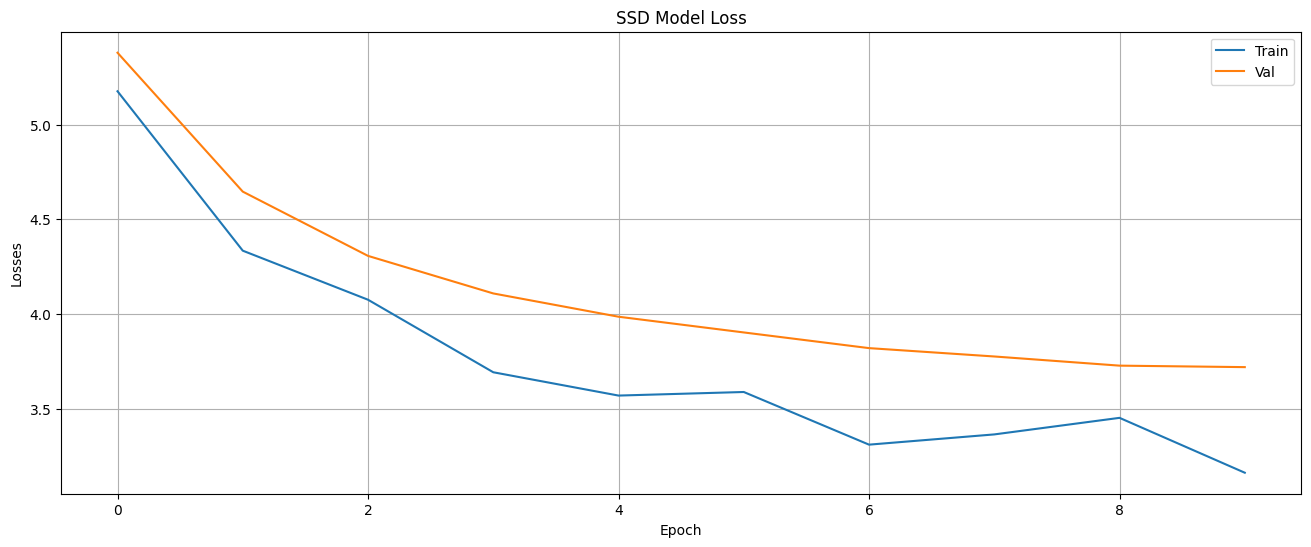

In [41]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(train_losses)
ax.plot(val_losses)
ax.legend(['Train', 'Val'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Losses')
ax.set_title('SSD Model Loss')
ax.grid()

#Inference Testing


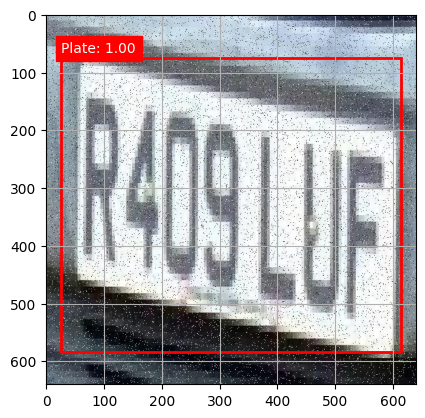

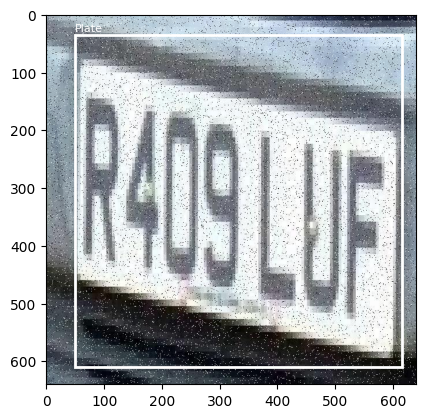

In [42]:

import torch
from PIL import Image
import torchvision.transforms as transforms

# Read a PIL image
img_id = 31
file_path = test_img_df['file_name'][test_img_df['id'] ==img_id][img_id]
image = Image.open(file_path)


# transform = transforms.PILToTensor()
# Convert the PIL image to Torch tensor
img_tensor = [preprocess(image).to(device)]
# print the converted Torch tensor
custom_model.to(device)
custom_model.eval()

test_dict = custom_model(img_tensor)
boxes = test_dict[0]['boxes']  # Example boxes
scores = test_dict[0]['scores']  # Example scores
classes = test_dict[0]['labels']  # Example classes  # Example class names

plot_predictions(img_tensor[0], boxes, scores, classes, CLASS_NAMES)

plot_image_with_annotations(img_id, test_img_df, test_ann_df)

#Save model

In [44]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [45]:
state_dict = torch.save(custom_model.state_dict(), '/content/gdrive/My Drive/MSc Project/Saved Models/ssd.pth')